In [1]:
%load_ext autoreload
%autoreload 2

# Load SAM

In [2]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model) #, crop_overlap_ratio = 750 / 1500) # , box_nms_thresh = 0.6 )

In [3]:
def move_to_device(segmentor_model, device="cuda"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

In [21]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "icbin"
rgb_path = "cnos_analysis/crop_proposals/000001.png" # f"datasets/bop23_challenge/datasets/{dataset}/test/000048/rgb/000001.png"
rgb = Image.open(rgb_path).convert("RGB")
sam_detections = custom_sam_model.generate_masks(np.array(rgb))

In [22]:
print("Image size", np.array(rgb).shape)
# sam_detections["masks"].int().sum(dim=(1,2)).chunk(26)

Image size (480, 640, 3)


# 2. Filter out too small and too big sam proposals

In [64]:
from torchvision.ops.boxes import batched_nms, box_area


def _remove_very_small_detections(masks, boxes): # after this step only valid boxes, masks are saved, other are filtered out
        min_box_size = 0.05 # relative to image size 
        min_mask_size = 300/(640*480) # relative to image size assume the pixesl should be in range (300, 10000) need to remove them 
        max_mask_size = 10000/(640*480) 
        img_area = masks.shape[1] * masks.shape[2]
        box_areas = box_area(boxes) / img_area
        mask_areas = masks.sum(dim=(1, 2)) / img_area
        keep_idxs = torch.logical_and(
            torch.logical_and(mask_areas > min_mask_size, mask_areas < max_mask_size),
            box_areas > min_box_size**2
        )

        return keep_idxs

keep_ids = _remove_very_small_detections(sam_detections["masks"], sam_detections["boxes"])

selected_masks = [sam_detections["masks"][i].cpu() for i in range(len(keep_ids)) if keep_ids[i]]
selected_bboxes = [sam_detections["boxes"][i].cpu() for i in range(len(keep_ids)) if keep_ids[i]]

selected_sam_detections = {
        "masks" : selected_masks,
        "bbox" : selected_bboxes
}

In [65]:
print(len(selected_masks))
print(len(sam_detections["masks"]))

90
151


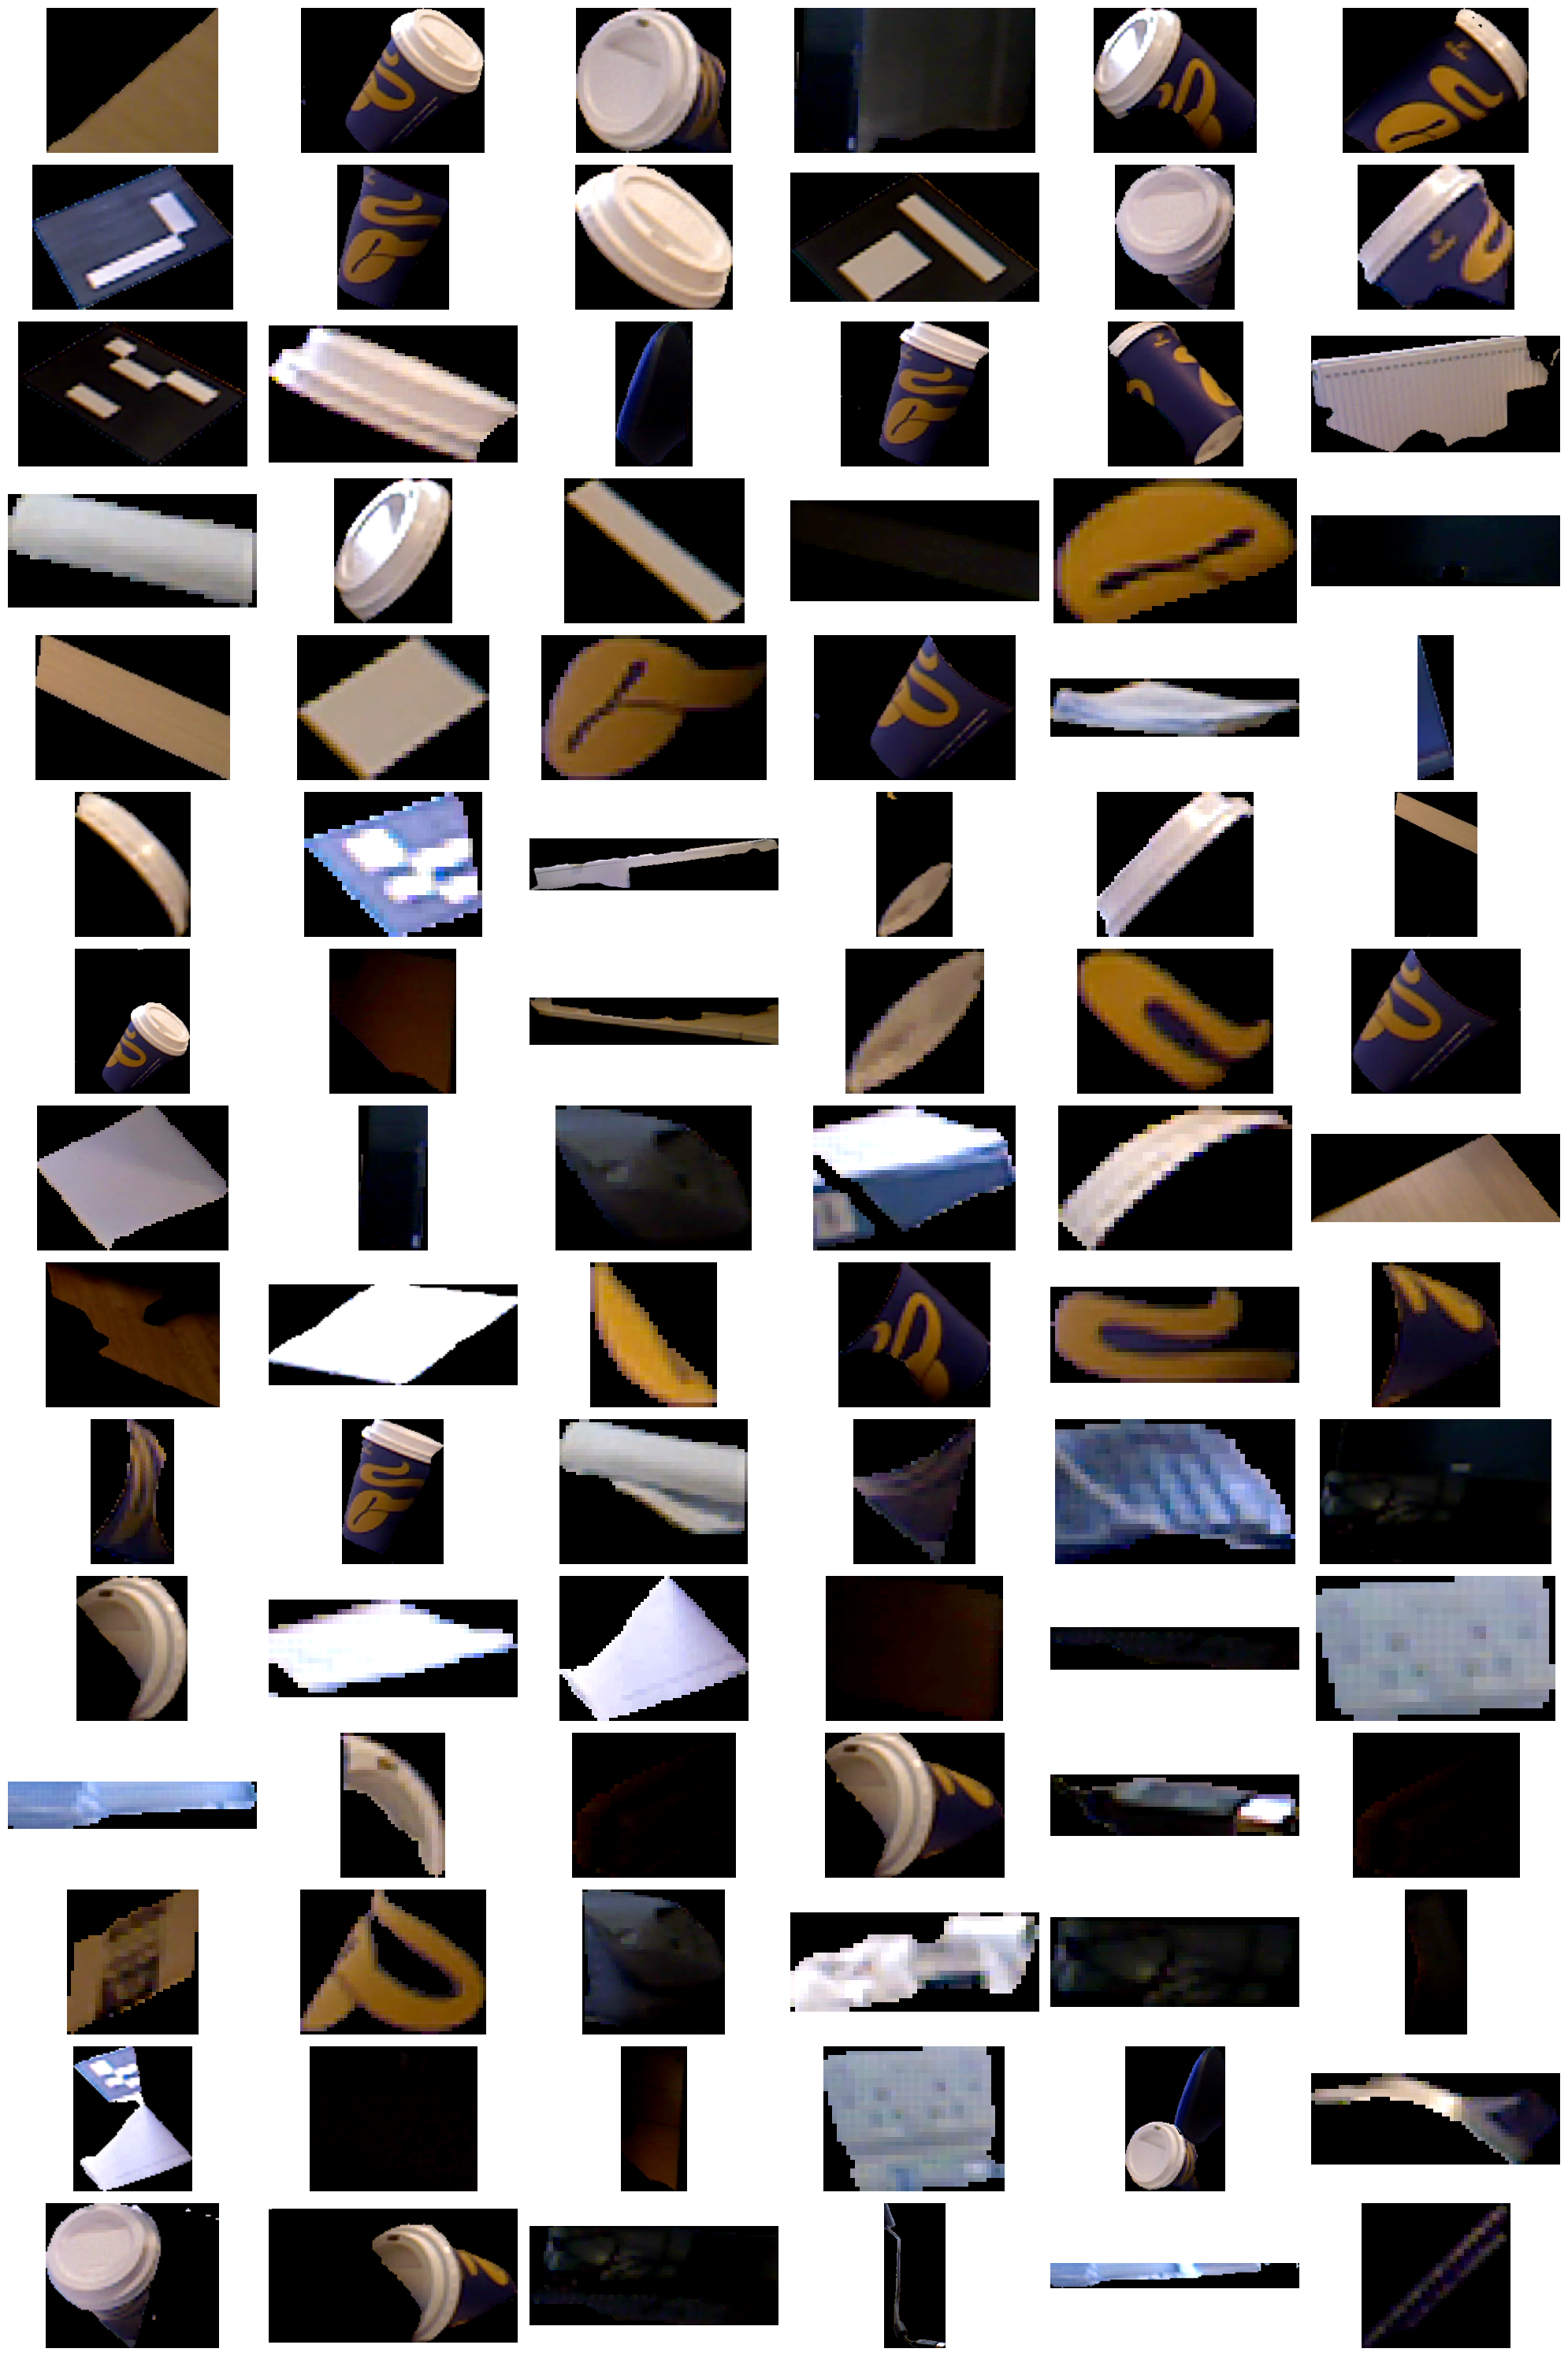

In [66]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in selected_masks:
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

# Visualize proposals
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define the number of rows and columns in the grid
rows = ceil(len(masked_images) / 6)
cols = 6
# Plot the masked_images array in a grid
plot_images(masked_images, rows, cols) 

# 3. Tighten the bboxes
Erosion and dilation to filter small details 


In [71]:
np.array(masked_images[84]).shape

(87, 104, 3)